# compute_mean_stratif
Compute mean stratification from time-averaged temperature and salinity. Take into account the grid deviation associated with the mean SSH.

Computation / storage is done sequentially over segments along the y direction. Running the entire notebook for eNATL60 data takes less than 10 minutes.

Typical chunking used: x=-1 (8354), y=200, z=10/30 (input / output)

This notebook is for processing eNATL60 data on occigen


In [1]:
from pathlib import Path
import os, datetime, time

import xarray as xr
from itidenatl.eos import bvf2

In [2]:
from dask.distributed import Client, LocalCluster, wait
scratch = os.getenv("SCRATCHDIR")
cluster = LocalCluster(n_workers=8, local_directory=scratch, threads_per_worker=4)#, memory_limit=8e6,silence_logs=50
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:41875 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 236.33 GiB


## 0) Parameters

In [10]:
client.restart()

Client Scheduler: tcp://127.0.0.1:42196 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 32 Memory: 236.33 GiB


In [3]:
scratch = Path(os.getenv("SCRATCHDIR"))
grid_dir = scratch #Path("/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-I/")
mean_dir = Path("/work/CT1/ige2071/SHARED/mean")

avg_type = "30d" # "30d" or "global"
avg_date = "20091227" # will be ignored if avg_type is "global"
chk_out = {"z_l":30} # this will update output chunks

#ssh_fname = "global_mean_gridT-2D.zarr"
vnames = {"T": "gridT", "S":"gridS"}
app = "_"+avg_date if avg_type=="30d" else ""

zgrd_fname = f"eNATL60_{avg_type}-mean_z-grid{app}.zarr"
temp_fname = "_".join([avg_type, "mean", vnames["T"]])+app+".zarr"
salt_fname = "_".join([avg_type, "mean", vnames["S"]])+app+".zarr"

out_fname = f"eNATL60_{avg_type}-mean_bvf{app}.zarr"
out_file = scratch/out_fname


## 1) Load Values

In [4]:
### load SSH, temperature and salinity: wrappers
#dims = {"ssh": ("x_c", "y_c"), "temp":("x_c", "y_c", "z_c"), "salt":("x_c", "y_c", "z_c")}
dimap = {"x":"x_c", "y":"y_c", "deptht":"z_c"}

def get_var(path, varname, chks={}):
    """ just a wrapper to open mean variables and adapt to xorca convention """
    print(varname)
    da = xr.open_zarr(path)[varname].squeeze()
    da = da.rename({dim:dimap[dim] for dim in da.dims})
    da = da.chunk({dim:chks[dim] for dim in da.dims})
    da = da.drop([c for c in da.coords])
    return da

In [5]:
### load data and arrange coordinates

ds = xr.open_zarr(scratch/zgrd_fname)
#chunks = ds.chunks

to_coords = ["depth_c_3d", "depth_l_3d", "e3t", "e3w", "tmask"]
to_coords = [co for co in to_coords if co in ds.data_vars]
ds = ds.set_coords(to_coords)

### load temperature and salinity
chks = {k:v[0] for k,v in ds.chunks.items() if k.endswith('c')}
#ds["votemper"] = get_var(mean_dir/temp_fname, "votemper", chks) 
#ds["vosaline"] = get_var(mean_dir/salt_fname, "vosaline", chks)
ds_ts = xr.merge([get_var(mean_dir/temp_fname, "votemper", chks), 
                 get_var(mean_dir/salt_fname, "vosaline", chks)
                 ])
ds = ds.merge(ds_ts, combine_attrs="override", compat="override")

### Select fields that are needed for computation
vars_need = ["votemper", "vosaline"] # I should use depth_l_3d
coor_need = ["e3w", "depth_l_3d", "tmask", "tmaskutil", "llon_cc", "llat_cc", "depth_l"]
ds = ds.get(vars_need+coor_need)
keep_coords = vars_need+coor_need+[k for k in ds.dims.keys()]
ds = ds.reset_coords([co for co in ds.coords if co not in keep_coords], drop=True)
print("dataset is {:.1f} GB".format(ds.nbytes/1e9))
ds

votemper
vosaline
dataset is 249.2 GB


,Array,Chunk
Bytes,88.30 GiB,127.47 MiB
Shape,"(300, 4729, 8354)","(10, 200, 8354)"
Count,721 Tasks,720 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,44.15 GiB,63.74 MiB
Shape,"(300, 4729, 8354)","(10, 200, 8354)"
Count,721 Tasks,720 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


## 2) Compute and store bvf
This takes around 7 minutes

In [6]:
bvf = bvf2(ds.where(ds.tmask), zcoord="depth_l_3d").astype("float32")

### deal with coordinates
bvf = bvf.reset_coords([co for co in bvf.coords if len(bvf[co].dims)>2], drop=True)
put_coords = ["llon_cc", "llat_cc", "depth_l"]
bvf = bvf.to_dataset().assign_coords({co:ds[co] for co in put_coords})
bvf = bvf.chunk({"z_l":chk_out.get("z_l", chks["z_c"])})
for var in bvf.coords:
    bvf[var].encoding.pop("chunks",None) # otherwise writing zarr raises error
    
### deal with attributes
put_attrs = {"from_files":[str(scratch/zgrd_fname), str(mean_dir/temp_fname),
                           str(mean_dir/salt_fname)],
             "simulation": "eNATL60", "processing notebook":"comp_mean_grid.ipynb",
             "date_processed":datetime.datetime.today().isoformat(timespec="minutes")
            }
bvf.attrs = put_attrs

In [7]:
### write attribute and create bvf in delayed mode in zarr archive
bvf.drop_vars("bvf").to_zarr(out_file, mode="w", compute=True, consolidated=True)
bvf.to_zarr(out_file, mode="a", compute=False)

Delayed('_finalize_store-1b5a8b13-2915-403d-aeeb-7508b64dd5de')

In [8]:
%%time
### compute and store (5'30)
Ny = bvf.y_c.size
nc_y = 400 # better if a multiple of chunk size # ram around 70 GB with nc_y=600
region = {d:slice(0, None) for d in bvf.dims}
for jy in range(0, Ny, nc_y):
    tmes = time.time()
    sliy = slice(jy, min(jy+nc_y,Ny))
    region["y_c"] = sliy
    zarit = bvf.isel(y_c=sliy).drop([c for c in bvf.coords])
    zarit.to_zarr(out_file, mode="a", region=region, compute=True)
    print(jy, round(time.time()-tmes), end="; ")

0 65; 400 31; 800 28; 1200 30; 1600 26; 2000 26; 2400 27; 2800 34; 3200 29; 3600 30; 4000 29; 4400 26; CPU times: user 1min 46s, sys: 12.3 s, total: 1min 58s
Wall time: 6min 20s


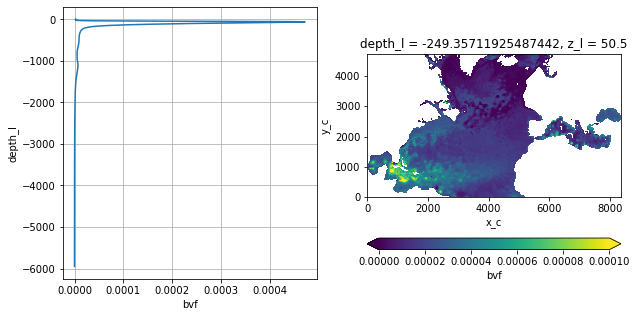

In [9]:
### verify the result:
from matplotlib import pyplot as plt
ds_re = xr.open_zarr(out_file)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
toplot = ds_re.bvf.isel(x_c=slice(3500,4000), y_c=slice(10,510)).mean(dim=("x_c","y_c"))
toplot.plot(y="depth_l", ax=axs[0])
axs[0].grid(True)

isel = dict(z_l=50, x_c=slice(0,None,4), y_c=slice(0,None,4))
ds_re.bvf.isel(isel).where(ds_re.tmaskutil).plot(ax=axs[1], vmin=0, vmax=1e-4,
                                                cbar_kwargs={'orientation':"horizontal"})
axs[1].set_aspect(1)

In [12]:
cluster.close()
client.close()

## post-processing
rechunk

In [13]:
ds_re = xr.open_zarr(out_file)
ds_re = ds_re.chunk({"x_c":200, "y_c":200})
for k in ds_re.coords.values():
    print(k.name, k.encoding.pop("chunks", None))
for k in ds_re.data_vars.values():
    print(k.name, k.encoding.pop("chunks", None))
ds_re

depth_l (300,)
llat_cc (400, 400)
llon_cc (400, 400)
tmaskutil (400, 400)
x_c (8354,)
y_c (4729,)
z_l (300,)
bvf (300, 400, 400)


<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, z_l: 300)
Coordinates:
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(200, 200), meta=np.ndarray>
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(200, 200), meta=np.ndarray>
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
Data variables:
    bvf        (z_l, y_c, x_c) float32 dask.array<chunksize=(300, 200, 200), meta=np.ndarray>
Attributes:
    grid_file:  /scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z.zarr
    mean_salt:  /work/CT1/ige2071/SHARED/mean/global_mean_gridS.zarr
    mean_temp:  /work/CT1/ige2071/SHARED/mean/global_mean_gridT.zarr

In [8]:
out_new = out_file.parent/(out_file.stem+"_chk200"+out_file.suffix)
out_new

PosixPath('/scratch/cnt0024/ige2071/nlahaye/global_mean_bvf_chk200.zarr')

In [15]:
%%time
ds_re.to_zarr(out_new, mode="w", consolidated=True)

CPU times: user 9.18 s, sys: 787 ms, total: 9.97 s
Wall time: 23.1 s


## Old stuff / unused

In [7]:
def get_bvf(ds, return_ds=False, astype=None):
    bvf = bvf2(ds.where(ds.tmask), zcoord="depth_l_3d").chunk({"z_l":chunks["z_l"]}) 
    if astype:
        bvf = bvf.astype(astype)
    bvf = bvf.reset_coords([co for co in bvf.coords if len(bvf[co].dims)>2], drop=True)
    if return_ds:
        put_coords = ["llon_cc", "llat_cc", "depth_l"]
        bvf = bvf.to_dataset().assign_coords({co:ds[co] for co in put_coords})
        for var in bvf.coords:
            bvf[var].encoding.pop("chunks",None) # otherwise writing zarr raise error
        put_attrs = {"grid_file":str(scratch/zgrd_fname), "mean_temp":str(mean_dir/temp_fname), 
                    "mean_salt":str(mean_dir/salt_fname)}
        bvf.attrs = put_attrs
    return bvf

In [9]:
from itertools import product
import time

def dist_write_chunks(ds, path, verbose=True, nchk=None):
    """ utilitary function that loops over chunks to store a DataArray in a zarr archive (append mode)"""
    #dim_chk = [next(di for di in da.dims if di.startswith(dim)) for dim in dims]
    if verbose:
        tmei = time.time()
    if isinstance(ds, xr.DataArray):
        name = ds.name if ds.name else "data"
        ds = ds.to_dataset(name=name)
    ### warning this is for testing
    ds = ds.chunk({"z_l":-1})
    
    dims = [*ds.chunks.keys()]
    chks = [np.r_[0, np.array(chk).cumsum()] for chk in ds.chunks.values()]
    if nchk:
        chks = [np.r_[chk[:-1:nchk], chk[-1]] for chk in chks]
        #ds = ds.chunk({di:ds.chunks[di][0]*nchk for di in ["x_c","y_c"] })
    #nks = [len(chk) for chk in ds.chunks.values()]
    nks = [len(chk)-1 for chk in chks] 
    if verbose:
        print("total number of chunks:", np.product(nks), dims, nks)
    ext = [np.arange(nk) for nk in nks]
    
    for chs in product(*ext):
        if verbose:
            tmes = time.time()
        isel = {dim:slice(*chks[ii][chs[ii]:chs[ii]+2]) for ii,dim in enumerate(dims)}
        sds = ds.isel(isel)
        if sds.tmaskutil.any():
            sds.to_zarr(path, mode="a", region=isel)
            if verbose:
                print("chunk {}: {:.0f} s".format(chs, time.time()-tmes), end="; ")
                #print(isel)
        else:
            print("chunk {} is masked: skip".format(chs), end="; ")
    if verbose:
        print("\n finished. Ellapsed time: {:.1f} min".format((time.time()-tmei)/60))

In [25]:
%%time
### Compute & store. (this is the fastest I found)
dist_write_chunks(get_bvf(ds.chunk({"z_l":50, "z_c":50}), return_ds=True, astype="float32"), 
                  out_file, nchk=2)

total number of chunks: 66 ['x_c', 'y_c', 'z_l'] [11, 6, 1]
chunk (0, 0, 0): 38 s; {'x_c': slice(0, 800, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (0, 1, 0): 29 s; {'x_c': slice(0, 800, None), 'y_c': slice(800, 1600, None), 'z_l': slice(0, 300, None)}
chunk (0, 2, 0) is masked: skip; chunk (0, 3, 0) is masked: skip; chunk (0, 4, 0) is masked: skip; chunk (0, 5, 0) is masked: skip; chunk (1, 0, 0): 29 s; {'x_c': slice(800, 1600, None), 'y_c': slice(0, 800, None), 'z_l': slice(0, 300, None)}
chunk (1, 1, 0): 31 s; {'x_c': slice(800, 1600, None), 'y_c': slice(800, 1600, None), 'z_l': slice(0, 300, None)}
chunk (1, 2, 0): 28 s; {'x_c': slice(800, 1600, None), 'y_c': slice(1600, 2400, None), 'z_l': slice(0, 300, None)}
chunk (1, 3, 0): 25 s; {'x_c': slice(800, 1600, None), 'y_c': slice(2400, 3200, None), 'z_l': slice(0, 300, None)}
chunk (1, 4, 0) is masked: skip; chunk (1, 5, 0) is masked: skip; chunk (2, 0, 0): 26 s; {'x_c': slice(1600, 2400, None), 'y_c': slice

## old stuff

In [9]:
from itertools import product

def dist_write_chunks(ds, path):
    """ utilitary function that loops over chunks to store a DataArray in a zarr archive (append mode)"""
    #dim_chk = [next(di for di in da.dims if di.startswith(dim)) for dim in dims]
    if isinstance(ds, xr.DataArray):
        name = ds.name if ds.name else "data"
        ds = ds.to_dataset(name=name)
    dims = [*ds.chunks.keys()]
    chks = [np.r_[0, np.array(chk).cumsum()] for chk in ds.chunks.values()]
    nks = [len(chk) for chk in ds.chunks.values()]        
    print("total number of chunks:", np.product(nks), dims, nks)
    ext = [np.arange(nk) for nk in nks]
    for chs in product(*ext):
        isel = {dim:slice(*chks[ii][chs[ii]:chs[ii]+2]) for ii,dim in enumerate(dims)}
        print("now writing", isel)
        ds.isel(isel).to_zarr(path, mode="a", region=isel)


In [10]:
%%time
bvf = get_bvf(ds, return_ds=True) # .isel(x_c=slice(0, 1200), y_c=slice(0, 1200))
bvf.drop_vars("bvf").to_zarr(out_file, mode="w", compute=True, consolidated=True)
bvf.to_zarr(out_file, mode="a", compute=False)
bvf

CPU times: user 2.93 s, sys: 251 ms, total: 3.18 s
Wall time: 5.52 s


<xarray.Dataset>
Dimensions:    (x_c: 8354, y_c: 4729, z_l: 300)
Coordinates:
  * z_l        (z_l) float64 0.5 1.5 2.5 3.5 4.5 ... 296.5 297.5 298.5 299.5
  * y_c        (y_c) int64 1 2 3 4 5 6 7 ... 4723 4724 4725 4726 4727 4728 4729
  * x_c        (x_c) int64 1 2 3 4 5 6 7 ... 8348 8349 8350 8351 8352 8353 8354
    tmaskutil  (y_c, x_c) int8 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llon_cc    (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    llat_cc    (y_c, x_c) float32 dask.array<chunksize=(400, 400), meta=np.ndarray>
    depth_l    (z_l) float64 dask.array<chunksize=(300,), meta=np.ndarray>
Data variables:
    bvf        (z_l, y_c, x_c) float64 dask.array<chunksize=(300, 400, 400), meta=np.ndarray>
Attributes:
    grid_file:  /scratch/cnt0024/ige2071/nlahaye/eNATL60_mean_grid_z.zarr
    mean_temp:  /work/CT1/ige2071/SHARED/mean/global_mean_gridT.zarr
    mean_salt:  /work/CT1/ige2071/SHARED/mean/global_mean_gridS.zarr

In [11]:
%%time 
### run computation and store
dist_write_chunks(bvf, path=out_file)

total number of chunks: 252 ['x_c', 'y_c', 'z_l'] [21, 12, 1]
now writing {'x_c': slice(0, 400, None), 'y_c': slice(0, 400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(400, 800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(800, 1200, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(1200, 1600, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(1600, 2000, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(2000, 2400, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(2400, 2800, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(2800, 3200, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, None), 'y_c': slice(3200, 3600, None), 'z_l': slice(0, 300, None)}
now writing {'x_c': slice(0, 400, No